## Scaling bipartite graph demo (tabformer)

### Overview

This notebooks demonstates the scaling capabilities of SynGen bipartite generators.

#### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets.tabformer import TabFormerPreprocessing

# Generator
from syngen.synthesizer import StaticBipartiteGraphSynthesizer, RandomSynthesizer
from syngen.generator.graph import RMATBipartiteGenerator

# evaluation
from syngen.analyzer.graph.frechet import get_frechet_score_directed_normalized

# utils
import math
import cudf
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from syngen.utils.types import MetaData

#### Prepare synthesizers


The synthesizer is prepared simply using the graph generator.

In this case no edge or node features will be generated.

In [2]:
static_graph_generator = RMATBipartiteGenerator()
preprocessing=TabFormerPreprocessing()

In [3]:
synthesizer = StaticBipartiteGraphSynthesizer(
                                    graph_generator=static_graph_generator,
                                    graph_info=preprocessing.graph_info,
                                    is_directed=False,
                                    )
random_synthesizer = RandomSynthesizer(is_directed=False, bipartite=True)

### Load data

The original dataset is loaded.

**Note**: to obtain the datasets run the `/scripts/get_datasets.sh` script as described in the `README.md`

In [4]:
data = preprocessing.transform('/workspace/data/tabformer/card_transaction.v2.csv', gpu = True)

num_edges = 978_288
num_nodes_src_set = 6_139
num_nodes_dst_set = 100_343
num_edges_src_dst = num_edges
num_edges_dst_src = num_edges

#### Fit graph

In [5]:
synthesizer.fit(edge_data=data[MetaData.EDGE_DATA])

In [6]:
synthesizer.graph_generator.get_fit_results()

((0.4464579119347037,
  0.05354208806529631,
  0.24409651989117281,
  0.25590348010882713),
 None)

#### Generate and compare graphs

To check the generator scaling capabilities we compare the results of randomly and properly generated graphs with the original graph. There is no trivial way to scale the original graph, so we use Normalized Frechet Score. It takes all of three graphs, normalizes their degree distribution curves using moving average, smoothes using log transformation,, computes [Frechet Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance) for original and generated graphs, and compares these distances.

In [7]:
(a,b,c,d), _ = synthesizer.graph_generator.get_fit_results()

tmp_alls = [
    ((a-x, b+x*1/4, c+x*1/4, d+x*2/4), x) for x in [0.15]    
]

alls = [((a, b, c, d), 0.0)] + tmp_alls + [((0.25, 0.25, 0.25, 0.25), 1.0)]

pprint(alls)

scalings = {}
plots = []

e_list_original = data[MetaData.EDGE_DATA].to_numpy()

for scaling in [-3, -2, -1, 0, 1, 2]:
    results = []
    n_num_nodes_src_set = int(num_nodes_src_set * 2**scaling)
    n_num_nodes_dst_set = int(num_nodes_dst_set * 2**scaling)
    n_num_edges_src_dst = int(num_edges_src_dst * 2**scaling * 2**scaling)
    n_num_edges_dst_src = int(num_edges_dst_src * 2**scaling * 2**scaling)
    print(scaling, n_num_nodes_src_set, n_num_nodes_dst_set, n_num_edges_src_dst, n_num_edges_dst_src)
    
    log2_row = math.ceil(math.log2(n_num_nodes_src_set))
    log2_col = math.ceil(math.log2(n_num_nodes_dst_set))
    
    generated_random_data = random_synthesizer.generate(
                num_nodes_src_set=n_num_nodes_src_set, num_nodes_dst_set=n_num_nodes_dst_set, 
                num_edges_src_dst=n_num_edges_src_dst, num_edges_dst_src=n_num_edges_dst_src,
                graph_noise=0.5)
    random_to_normalize_list = generated_random_data[MetaData.EDGE_DATA].to_numpy()
    
    
    for theta, x in alls:    
        synthesizer.graph_generator.set_fit_results((theta, None))        
        generated_data = synthesizer.generate(n_num_nodes_src_set, 
                                              n_num_nodes_dst_set, 
                                              n_num_edges_src_dst, 
                                              n_num_edges_dst_src,
                                              graph_noise=0.5)
        e_list = generated_data[MetaData.EDGE_DATA].to_numpy()
        
        dd, out_dd, in_dd = get_frechet_score_directed_normalized(e_list_original, e_list, random_to_normalize_list, cdf_points=1000)    
        a_n, b_n, c_n, d_n = theta
        theta_new = np.around(a_n, 2), np.around(b_n, 2), np.around(c_n, 2), np.around(d_n, 2)
        results.append(
        [(theta_new, x, np.around(dd, 2)), 
         (theta_new, x, np.around(out_dd, 2)),
         (theta_new, x, np.around(in_dd, 2))]
        )
            
        plots.append((theta_new, x, e_list))
    scalings[scaling] = results

[((0.4464579119347037,
   0.05354208806529631,
   0.24409651989117281,
   0.25590348010882713),
  0.0),
 ((0.2964579119347037,
   0.09104208806529632,
   0.2815965198911728,
   0.33090348010882714),
  0.15),
 ((0.25, 0.25, 0.25, 0.25), 1.0)]
-3 767 12542 15285 15285


/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-2 1534 25085 61143 61143
-1 3069 50171 244572 244572
0 6139 100343 978288 978288
1 12278 200686 3913152 3913152
2 24556 401372 15652608 15652608


In [8]:
pprint(scalings)

{-3: [[((0.45, 0.05, 0.24, 0.26), 0.0, 0.08),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0.06),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0)],
      [((0.3, 0.09, 0.28, 0.33), 0.15, 0.14),
       ((0.3, 0.09, 0.28, 0.33), 0.15, 0.01),
       ((0.3, 0.09, 0.28, 0.33), 0.15, 0.13)],
      [((0.25, 0.25, 0.25, 0.25), 1.0, 0.14),
       ((0.25, 0.25, 0.25, 0.25), 1.0, 0),
       ((0.25, 0.25, 0.25, 0.25), 1.0, 0)]],
 -2: [[((0.45, 0.05, 0.24, 0.26), 0.0, 0),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0.04),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0.02)],
      [((0.3, 0.09, 0.28, 0.33), 0.15, 0.14),
       ((0.3, 0.09, 0.28, 0.33), 0.15, 0),
       ((0.3, 0.09, 0.28, 0.33), 0.15, 0.03)],
      [((0.25, 0.25, 0.25, 0.25), 1.0, 0.0),
       ((0.25, 0.25, 0.25, 0.25), 1.0, 0.02),
       ((0.25, 0.25, 0.25, 0.25), 1.0, 0.01)]],
 -1: [[((0.45, 0.05, 0.24, 0.26), 0.0, 0.06),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0.04),
       ((0.45, 0.05, 0.24, 0.26), 0.0, 0)],
      [((0.3, 0.09, 0.28, 0.33), 0.15, 0.08)

#### Show results

The original dataset is loaded.

**Note**: to obtain the datasets run the `/scripts/get_datasets.sh` script as described in the `README.md`

In [9]:
d1, d2, d3 = [[], [], 'NA'], [[], [], 'NA'], [[], [], 'NA']
o1, o2, o3 = [[], [], 'NA'], [[], [], 'NA'], [[], [], 'NA']
i1, i2, i3 = [[], [], 'NA'], [[], [], 'NA'], [[], [], 'NA']

def add_results(p1, p2, p3, data):
    a, b, c = data
    if b < 0.1:
        p1[1].append(c)
        p1[2] = f'{a} | {b}'
    elif b < 0.2:
        p2[1].append(c)
        p2[2] = f'{a} | {b}'
    elif b < 2.0:
        p3[1].append(c)
        p3[2] = f'{a} | {b}'

def add_values(p1, p2, p3, x):
    p1[0].append(x)
    p2[0].append(x)
    p3[0].append(x)  
        

for x, values in scalings.items():
    add_values(d1, d2, d3, x)
    add_values(o1, o2, o3, x)
    add_values(i1, i2, i3, x)
    
    for all_results in values:
        dd_res = all_results[0]
        add_results(d1, d2, d3, dd_res)
        out_dd_res = all_results[1]
        add_results(o1, o2, o3, out_dd_res)
        in_dd_res = all_results[2]
        add_results(i1, i2, i3, in_dd_res)


Text(0, 0.5, 'Normalized frechet distance (higher is better)')

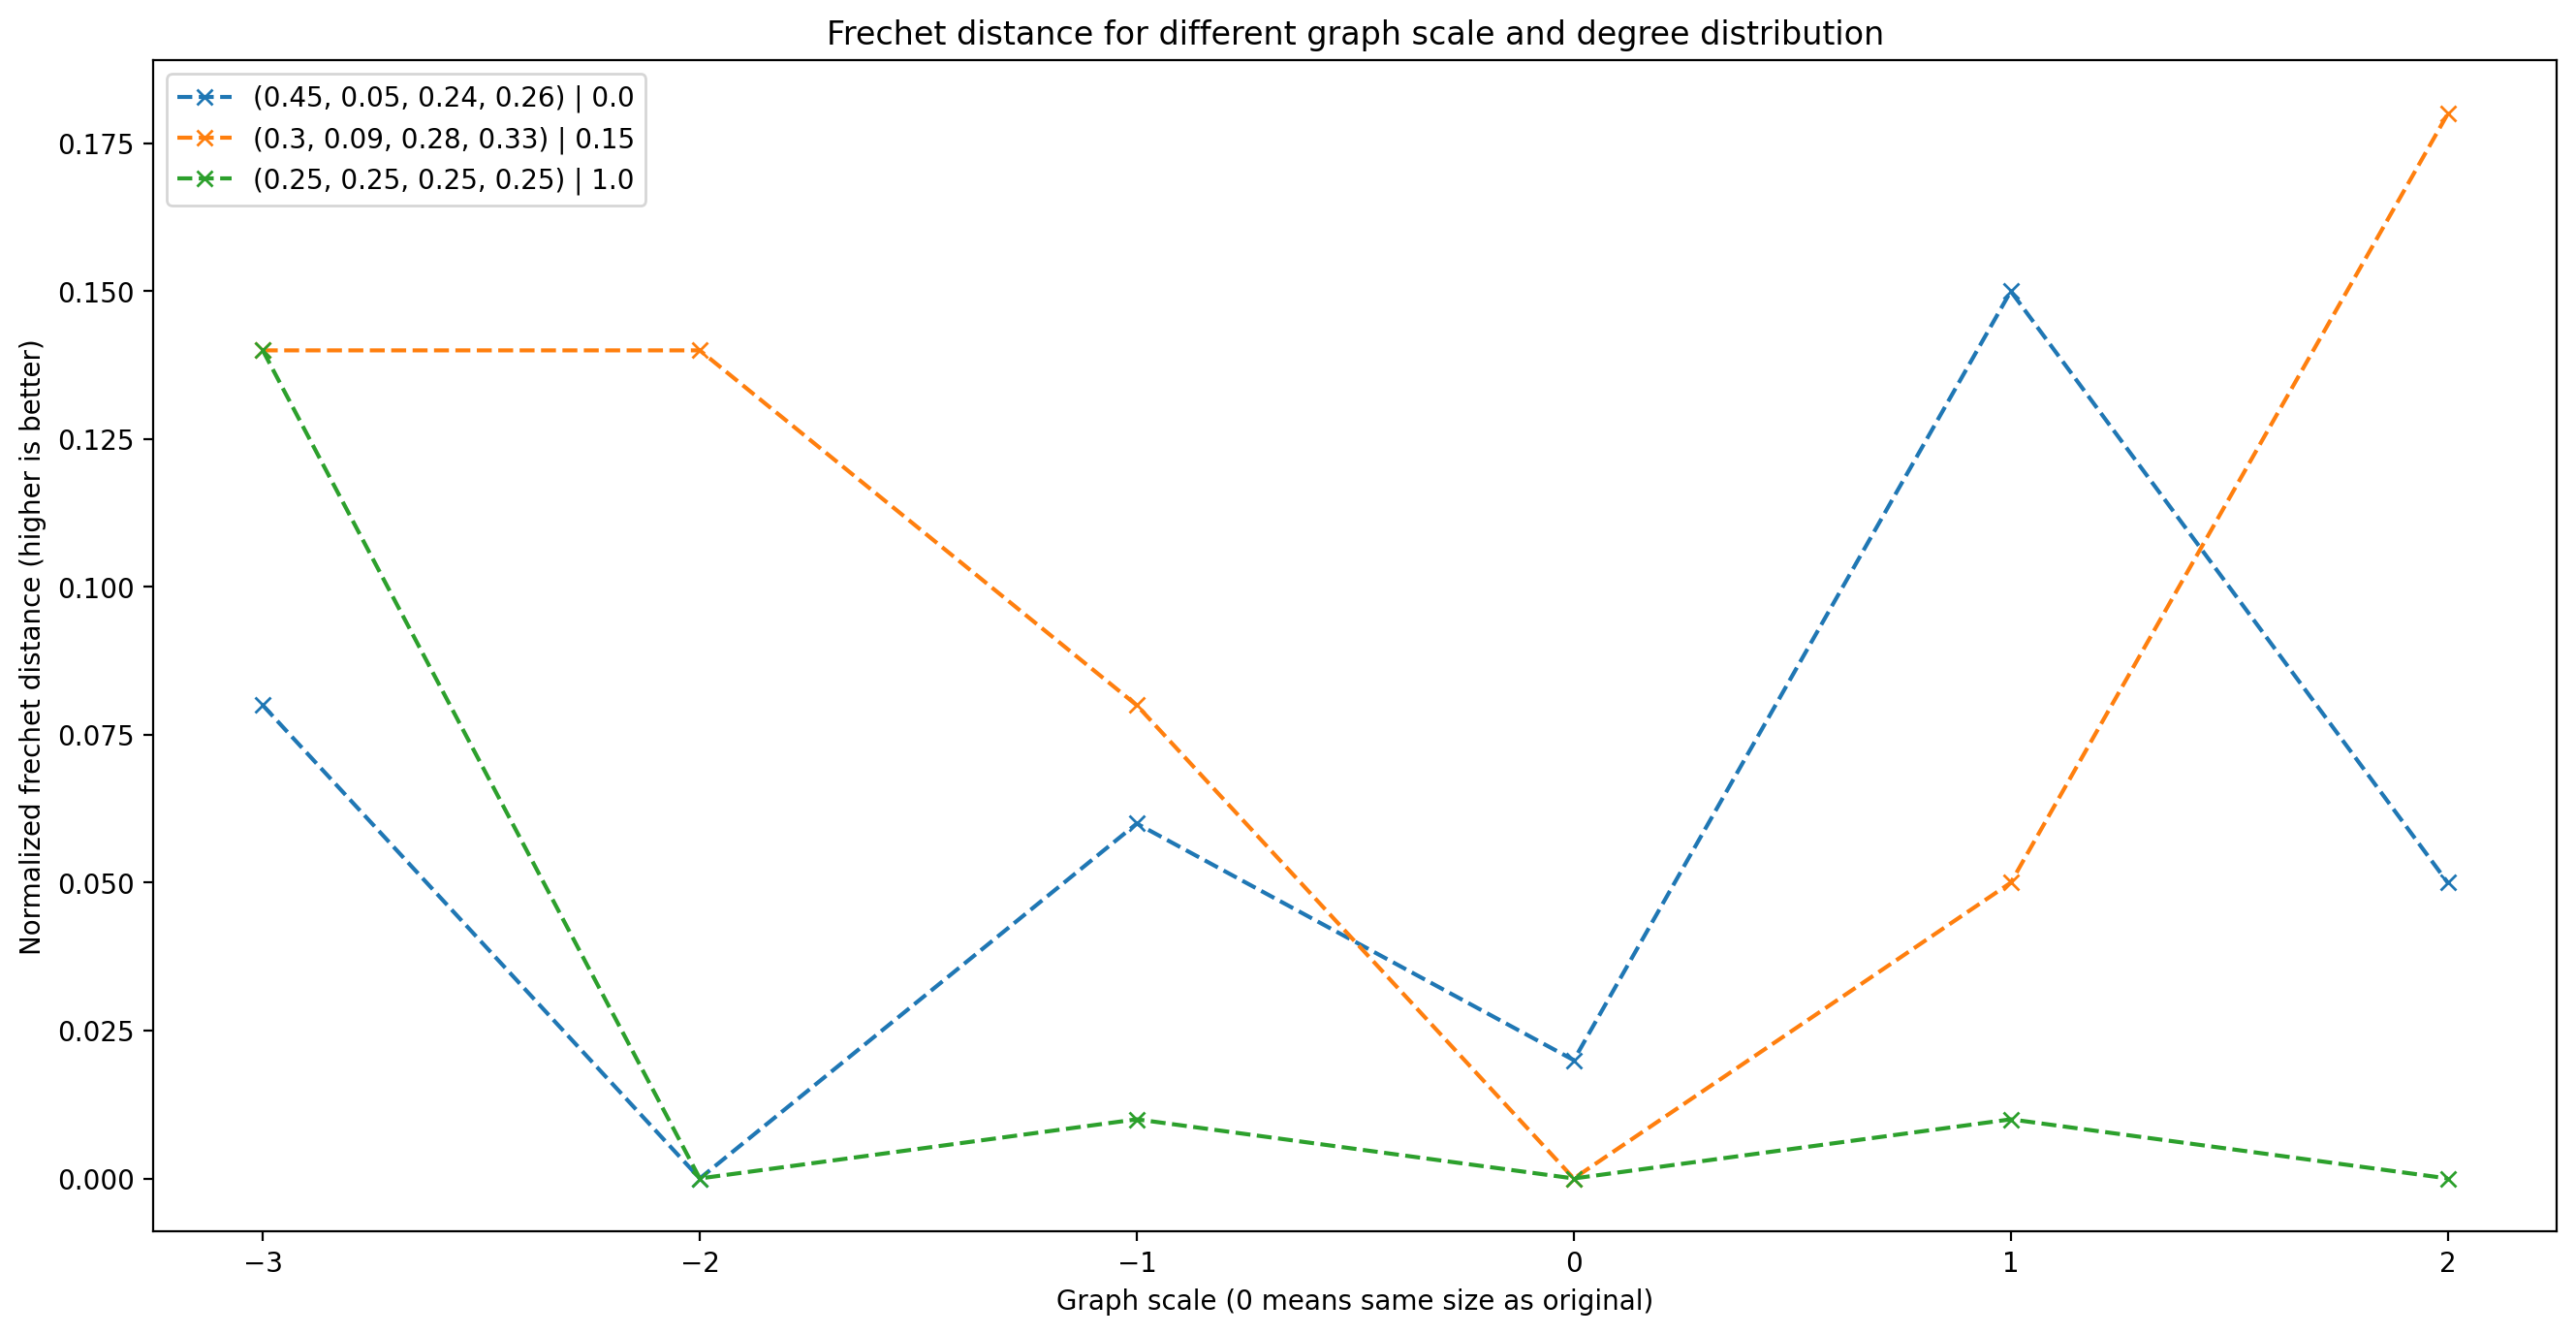

In [10]:
plt.figure(figsize=(16, 8), dpi=200)


for xs, ys, text in [d1, d2, d3]:
    plt.plot(xs, ys, '--x', label=text)

plt.legend()
plt.title('Frechet distance for different graph scale and degree distribution')
plt.xlabel("Graph scale (0 means same size as original)")
plt.ylabel("Normalized frechet distance (higher is better)")

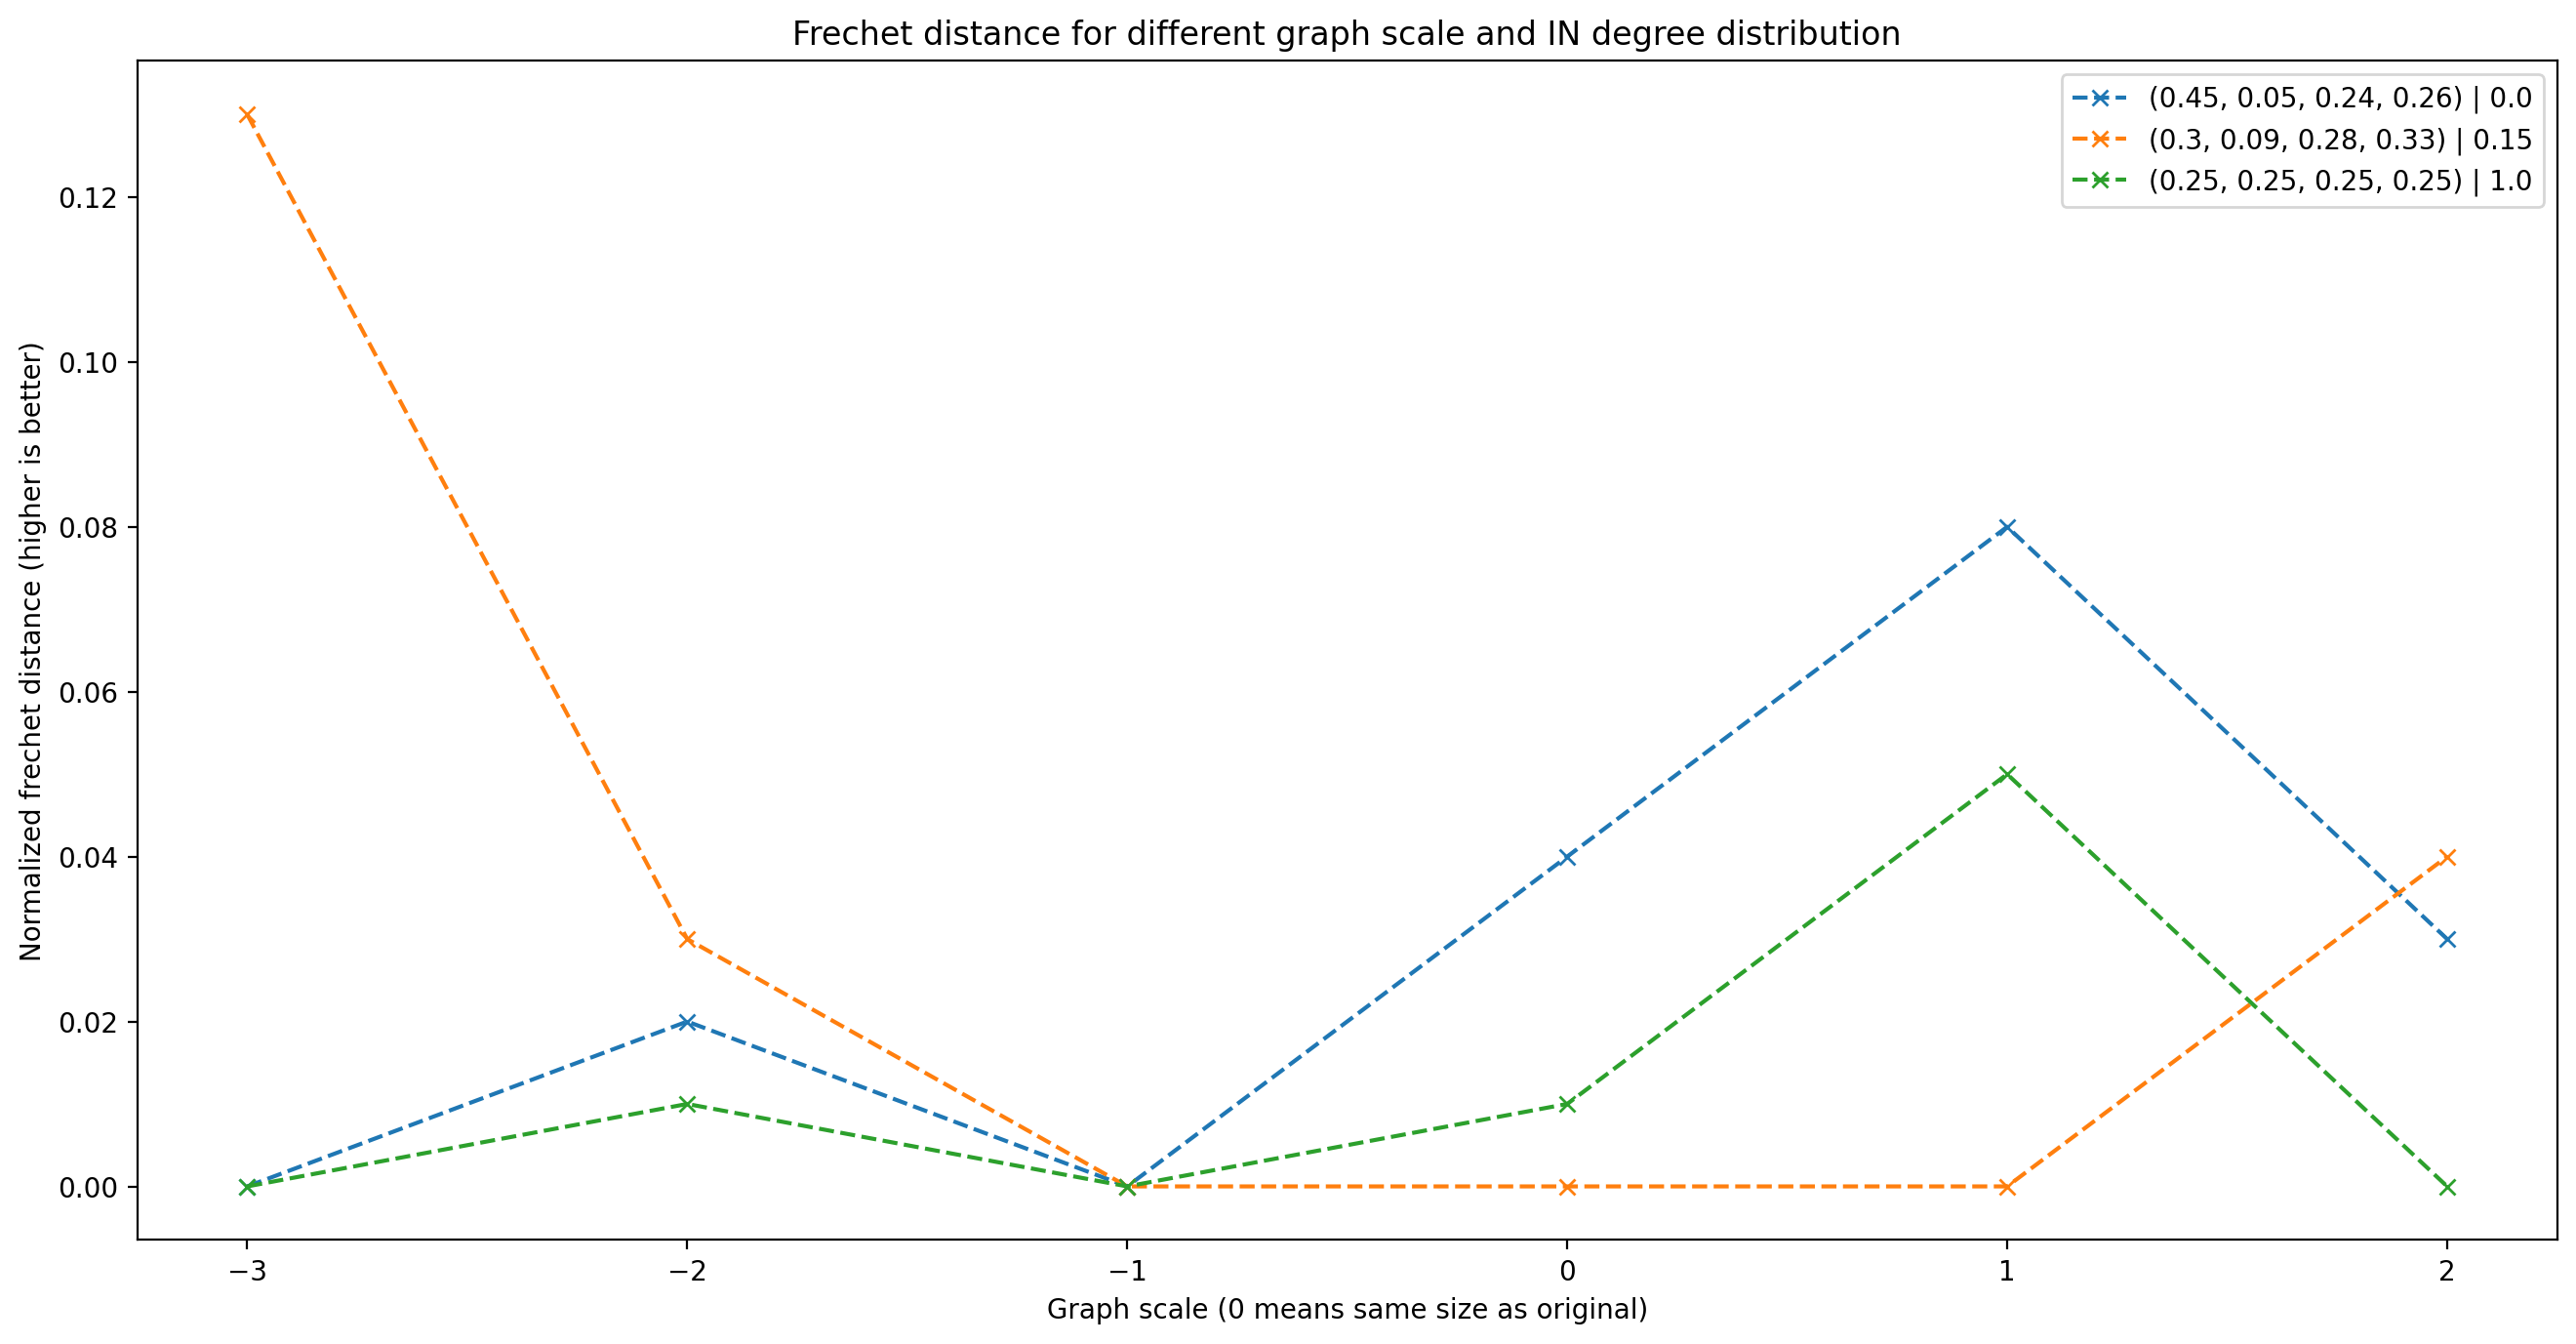

In [11]:
plt.figure(figsize=(16, 8), dpi=200)


for xs, ys, text in [i1, i2, i3]:
    plt.plot(xs, ys, '--x', label=text)
    
plt.legend()
plt.title('Frechet distance for different graph scale and IN degree distribution')
plt.xlabel("Graph scale (0 means same size as original)")
plt.ylabel("Normalized frechet distance (higher is better)")
plt.show()

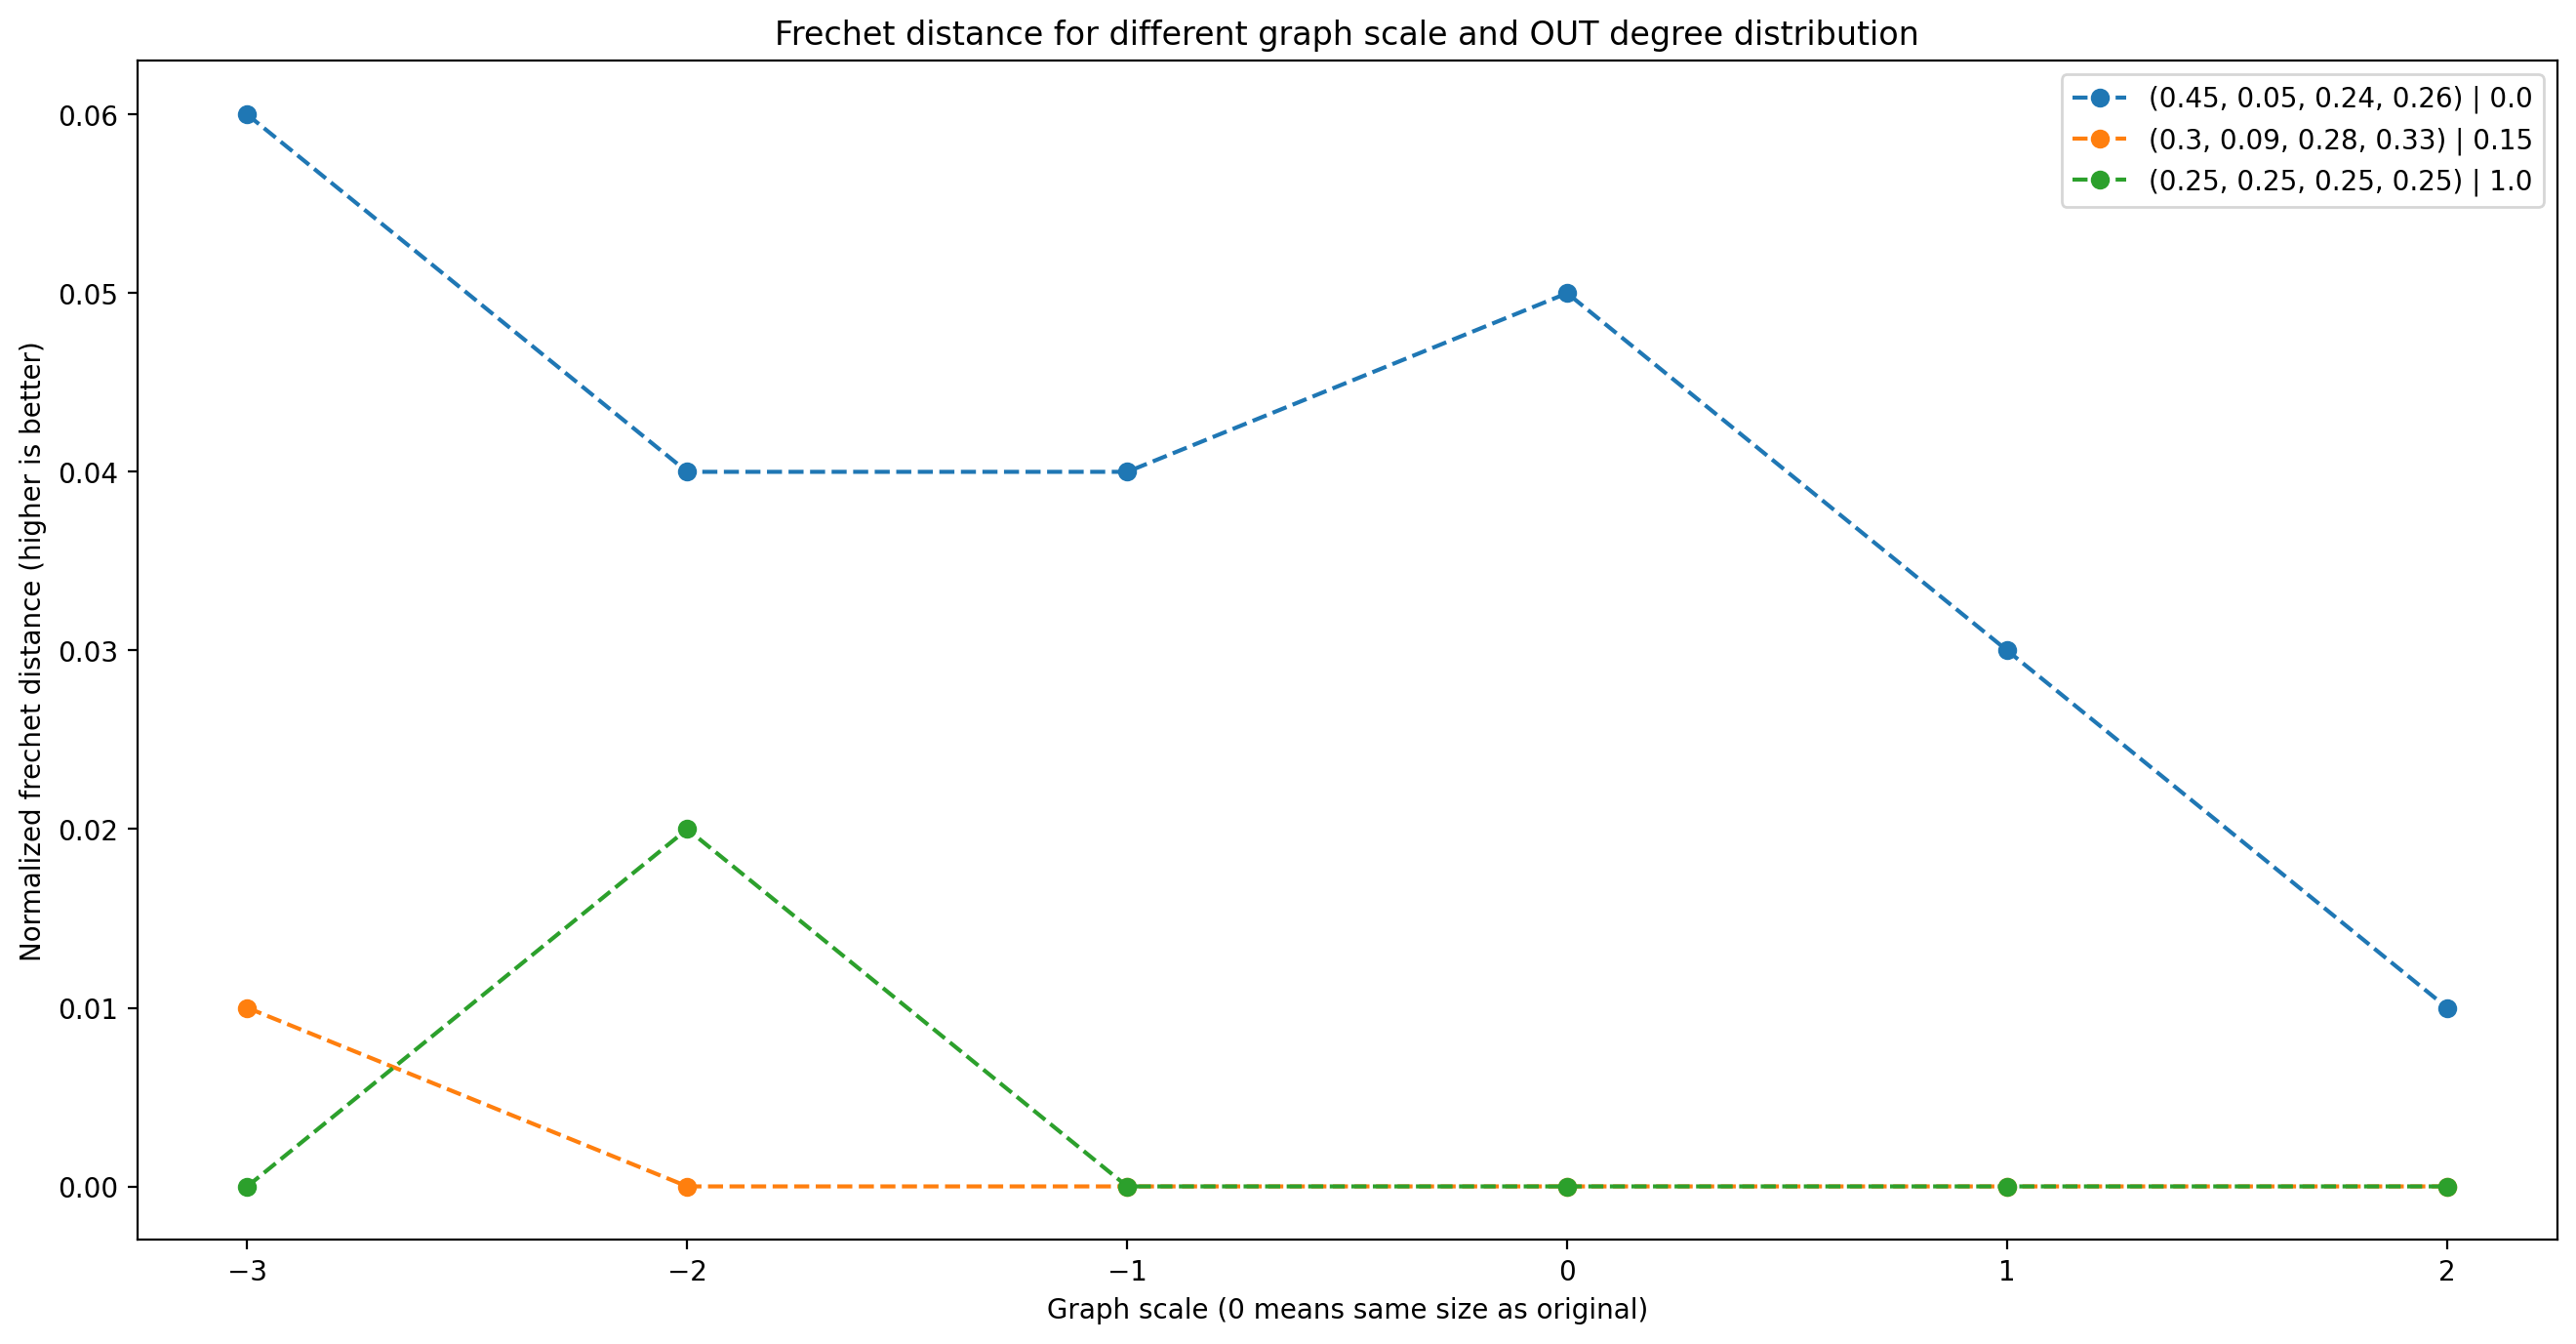

In [12]:
plt.figure(figsize=(16, 8), dpi=200)


for xs, ys, text in [o1, o2, o3]:
    plt.plot(xs, ys, '--o', label=text)
    
plt.legend()
plt.title('Frechet distance for different graph scale and OUT degree distribution')
plt.xlabel("Graph scale (0 means same size as original)")
plt.ylabel("Normalized frechet distance (higher is better)")
plt.show()